# Quiz 3 - Global Freight Route Analysis - Deep Learning

# Predict the cost to ship fine art

A shipping company specializing in the shipment of artwork has hired you as an supply chain management alum and tasked you to build a model that predicts the cost of shipping paintings, antiques, sculptures, and other collectibles to customers based on the information provided in the dataset. The dataset consists of parameters such as the artist’s name and reputation, dimensions, material, and price of the collectible, shipping details such as the customer information, scheduled dispatch, delivery dates, and so on.

## Data

As you learned in SCM.256 H3, you establish a pipeline that imputes missing values. In addition:
* The numerical features `Weight` and `Height` of the artworks are transformed by removing the mean and scaling to unit variance using the StandardScaler.
* The categorical features `Customer Information` (Wealthy, Working Class), `Material` (Wood, Glass, Brass, Stone, Clay, Marble, etc.) and `Transport` (Airways, Waterways, Roadways) are one-hot encoded. 
* The binary features `Remote Location`, `Fragile`, `Installation Included`, `International`, `Express Shipment` are encoded using `0` for No and `1` for Yes, using an OrdinalEncoder.

You etablish a train-test split of 80-20% and fit your pipeline on the training data.

## Setting Up the Workspace

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import Pipeline
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Loading the Data

In [2]:
df = pd.read_csv('https://www.dropbox.com/s/k9ajua3yfa1cnuo/shipping_costs.csv?dl=1')

In [3]:
df

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,fffe3800370037003300,Jeffrey Freudenthal,0.37,37.0,10.0,16551.0,Brass,28.28,38.46,Yes,Yes,No,Airways,No,Wealthy,Yes,03/28/18,03/25/18,"New Robert, VT 85335",872.43
6496,fffe310036003400,Larry Edwards,0.67,15.0,NaN,18981.0,NaN,67.18,27.72,No,No,No,Roadways,No,Working Class,No,08/29/15,08/27/15,"New Joshua, VA 35766",1347.02
6497,fffe3600300031003300,Denise Worth,0.68,19.0,8.0,587.0,Clay,6.92,10.38,Yes,No,No,NaN,Yes,Wealthy,No,04/10/19,04/09/19,"Lake Kelly, MA 80823",354.55
6498,fffe3600350035003900,Daniel Drew,0.02,33.0,9.0,1269377.0,Stone,2929.13,69.76,No,Yes,No,Roadways,No,Working Class,Yes,03/10/19,03/12/19,"Hintonberg, UT 35006",5037.50


In [4]:
y = df.Cost

X = df[['Remote Location','Customer Information','Fragile','Transport','Installation Included','Express Shipment','International','Base Shipping Price','Price Of Sculpture','Material','Weight','Height','Artist Reputation']].copy()

In [5]:
X.dtypes

Remote Location           object
Customer Information      object
Fragile                   object
Transport                 object
Installation Included     object
Express Shipment          object
International             object
Base Shipping Price      float64
Price Of Sculpture       float64
Material                  object
Weight                   float64
Height                   float64
Artist Reputation        float64
dtype: object

## Pipeline

In [6]:
#Establish each pipeline for differente feature types
categorical_features = ['Customer Information','Material', 'Transport']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')), #Impute missing by using the most frequent value along each column
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) #Encode as one-hot

categorical_ordinal_features = ['Remote Location','Fragile','Installation Included','International','Express Shipment']
categorical_ordinal_values = [
    ['No', 'Yes'] 
]* len (categorical_ordinal_features)
cat_ord_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='No')), #Impute missing values by setting them as 'Missing'
    ('encoder', OrdinalEncoder(handle_unknown='error', #We should not see unknown values, as they are all imputed in the pipeline
                                     categories=categorical_ordinal_values))]) #Encode as ordinal, in order as given.

num_features = ['Weight','Height']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()), #Impute missing values by setting those to the mean value along each column
    ('standardscaler', MinMaxScaler())]) #Standardize numerical features by removing the mean and scaling to unit variance

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (cat_ord_pipe, categorical_ordinal_features),
    (num_pipe, num_features), 
    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Customer Information', 'Material',
                                  'Transport']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='No',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['No',
                                                                              'Yes']]))]),
                                 ['Remote Location', 'Fragile',
                                  'Installation Included', 'International',
                                  'Express Shipment']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  MinMaxScaler())]),
                                 ['Weight', 'Height'])],
                  verbose_feature_names_out=False)

In [7]:
#Split into 80-20 train-test set, data IS shuffled before splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train.head(3)

,Remote Location,Customer Information,Fragile,Transport,Installation Included,Express Shipment,International,Base Shipping Price,Price Of Sculpture,Material,Weight,Height,Artist Reputation
889,No,Working Class,Yes,Airways,Yes,No,No,19.42,4.70,Clay,51.0,4.0,0.00
4385,No,Working Class,Yes,Roadways,No,No,No,19.05,9.20,Clay,2729.0,31.0,0.62
4919,No,Wealthy,No,Roadways,No,Yes,No,90.95,1011.11,Stone,233674.0,18.0,0.37


In [8]:
#We first need to fit each step in our pipeline to the training data.
preprocessor.fit(X_train)

#Now we can transform our data, with the steps specified in the pipeline
#The output of transform() our pipeline is a numpy array.
# We convert this data back into a pandas dataframe using the list of feature names stored in our preprocessor.

Xprocessed_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)

#Note the changed order of the index caused by the shuffling in train_test_split!
display(Xprocessed_train_df)

,Customer Information_Wealthy,Customer Information_Working Class,Material_Aluminium,Material_Brass,Material_Bronze,Material_Clay,Material_Marble,Material_Stone,Material_Wood,Transport_Airways,Transport_Roadways,Transport_Waterways,Remote Location,Fragile,Installation Included,International,Express Shipment,Weight,Height
889,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.070285e-07,0.014286
4385,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.311583e-05,0.400000
4919,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981474e-03,0.214286
4794,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,4.276343e-05,0.057143
5438,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.321740e-04,0.328571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.868606e-07,0.085714
5191,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.611154e-07,0.028571
5226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.034125e-04,0.271429
5390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.076294e-03,0.269403


In [9]:
y_train.describe()

count    5.200000e+03
mean     1.836884e+04
std      2.629349e+05
min     -8.801727e+05
25%      1.908050e+02
50%      3.850200e+02
75%      1.163003e+03
max      1.114343e+07
Name: Cost, dtype: float64

We have already used a MinMaxScaler in our pipeline to scale our features. We are also going to need to scale our dependent variable.

In [10]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.to_frame())
y_test_scaled = scaler.transform(y_test.to_frame())

## Deep learning



### Initial Model

Minimum validation loss: 0.03947937488555908


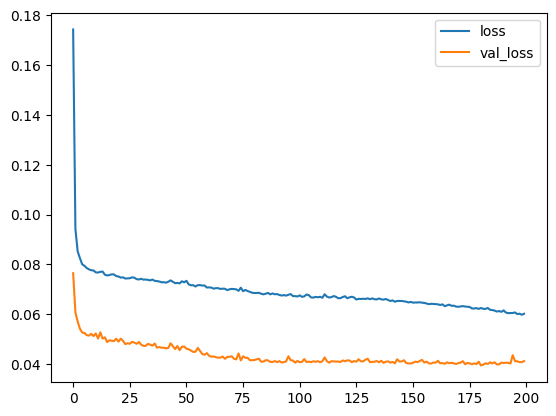

In [11]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[Xprocessed_train_df.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves
)
#import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Q: Share your interpretation of the plotted curve of the loss function. 

### Add Capacity

Minimum validation loss: 0.04143664985895157


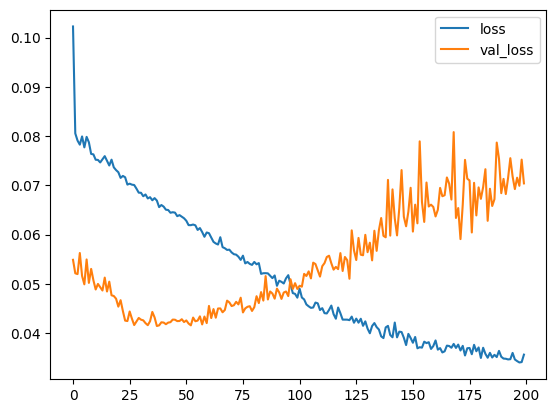

In [12]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[Xprocessed_train_df.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves
)
#import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Q: Share your interpretation of the plotted curve of the loss function. What is the effect of the higher capacity?

### Add Dropout Layers

Minimum validation loss: 0.04160868749022484


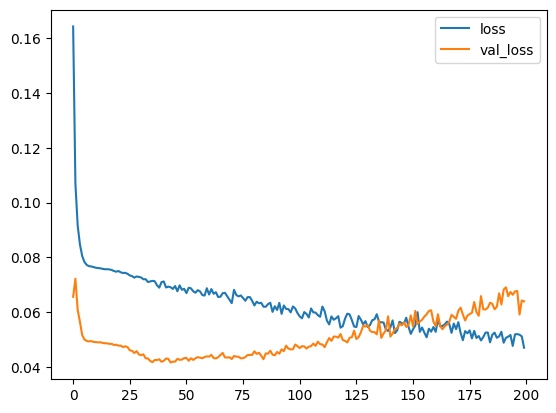

In [13]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[Xprocessed_train_df.shape[1]]),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Q: Share your interpretation of the plotted curve of the loss function. What is the effect of the dropout layers?


### Add Batch Normalization Layers

In [14]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[Xprocessed_train_df.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

KeyboardInterrupt: ignored

#### Q: Share your interpretation of the plotted curve of the loss function. What is the effect of the batch normalization layers?

### Tweak Dropout Rate

In [ ]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
 layers.BatchNormalization(input_shape=[Xprocessed_train_df.shape[1]]),
 layers.Dense(256, activation='relu'),
 layers.BatchNormalization(),
 layers.Dropout(0.2),
 layers.Dense(256, activation='relu'),
 layers.BatchNormalization(),
 layers.Dropout(0.2),
 layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Q: Share your interpretation of the plotted curve of the loss function. What is the effect of tweaking the dropout rate?

### Add Early Stopping

Add early stopping to the best of the three models (lowest validation loss), so that the model stops training, if there is no improvement in the validation loss by 0.00001 for 10 epochs. Restore the model weights from the epoch with the best value of the validation loss.

***Additionally copy the content of this cell with the answer into canvas***

*Tip: you do not have the run the models in the cells above*

Minimum validation loss: 0.04118165373802185


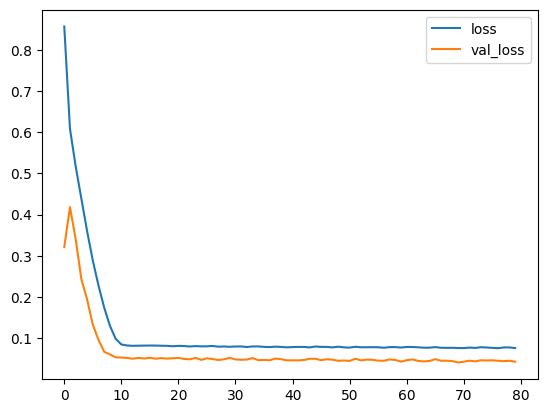

In [18]:
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import callbacks

#Copy specification of the layers with the lowest validation loss
model = keras.Sequential([
 layers.BatchNormalization(input_shape=[Xprocessed_train_df.shape[1]]),
 layers.Dense(256, activation='relu'),
 layers.BatchNormalization(),
 layers.Dropout(0.2),
 layers.Dense(256, activation='relu'),
 layers.BatchNormalization(),
 layers.Dropout(0.2),
 layers.Dense(1),
])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
) # Add early stopping callback

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train_scaled,
    validation_data=(Xprocessed_test_df, y_test_scaled),
    batch_size=128,
    epochs=200,
    verbose=0, #suppress output since we'll plot the curves,
    callbacks=[early_stopping], # Add early stopping callback
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# *PLEASE UPLOAD YOUR NOTEBOOK TO CANVAS*